In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier 
from utils.functions import *
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import optuna
import shap
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Part I: Find predictors of influence

In [37]:
# Read data
data = pd.read_csv('data/train.csv')
data.head()

Choice  A_follower_count  A_following_count  A_listed_count  \
0       0               228                302               3   
1       0             21591               1179             228   
2       0              7310               1215             101   
3       0                20                  7               2   
4       1             45589                862            2641   

   A_mentions_received  A_retweets_received  A_mentions_sent  A_retweets_sent  \
0             0.583979             0.100503         0.100503         0.100503   
1            90.456506            25.798292         5.709329         1.111159   
2            25.503644             9.556347         5.361519         0.591206   
3             7.690824             0.277306         1.331508         0.100503   
4           148.854279            36.998884        27.881768         3.333492   

     A_posts  A_network_feature_1  A_network_feature_2  A_network_feature_3  \
0   0.362150                    2           166.500000         11355.000000   
1   5.176620                  369            18.442971          1330.366048   
2   3.589718                   95            68.927835          5999.896907   
3   2.830627                    6             2.000000            96.166667   
4  23.861282                  551           127.404293          2833.847943   

   B_follower_count  B_following_count  B_listed_count  B_mentions_received  \
0             34463              29808            1689            15.430498   
1             39262                848            1610            40.495021   
2              3622                482             206             0.734696   
3             19562              17637             278           572.874856   
4              7554               1711             181            21.601866   

   B_retweets_received  B_mentions_sent  B_retweets_sent    B_posts  \
0             3.984029         8.204331         0.332423   6.988815   
1             8.943607         3.227677         0.564343   1.070321   
2             0.354379         0.603202         0.100503   0.603202   
3           390.293681        27.552040         7.167557  32.101906   
4             3.581661         6.764657         1.119727   4.563246   

   B_network_feature_1  B_network_feature_2  B_network_feature_3  
0                   66            75.530303          1916.893939  
1                  163           132.030675          2931.515337  
2                    3            10.333333           277.333333  
3                 1762            23.469296          1395.845634  
4                   85            48.500000          1993.627907

### Exploratory data analysis

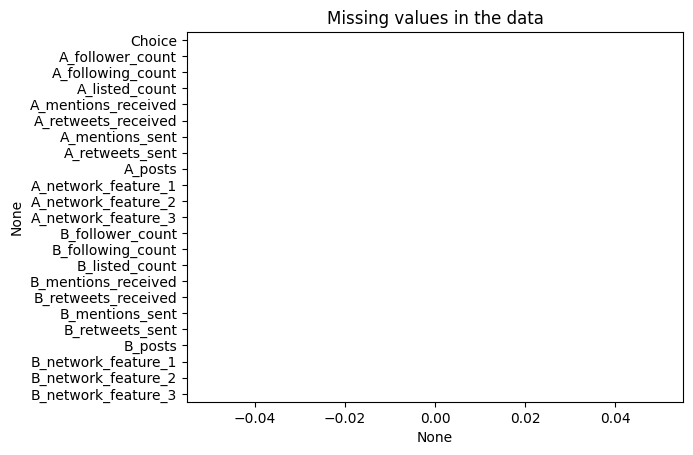

In [38]:
# Exploratory data analysis

sns.barplot(x = data.isna().mean(), y = data.isna().mean().index)
plt.title('Missing values in the data')
plt.show()

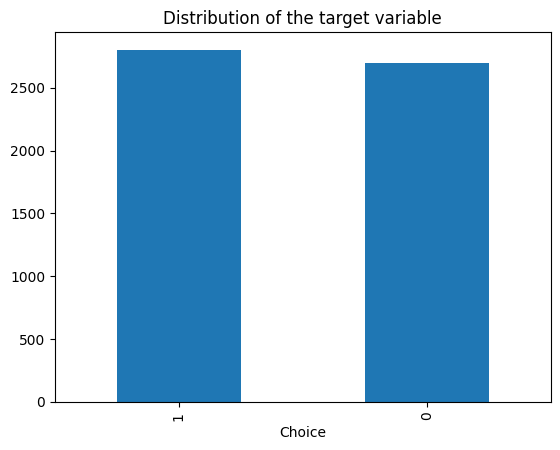

In [6]:
data['Choice'].value_counts().plot(kind = 'bar')
plt.title('Distribution of the target variable')
plt.show()

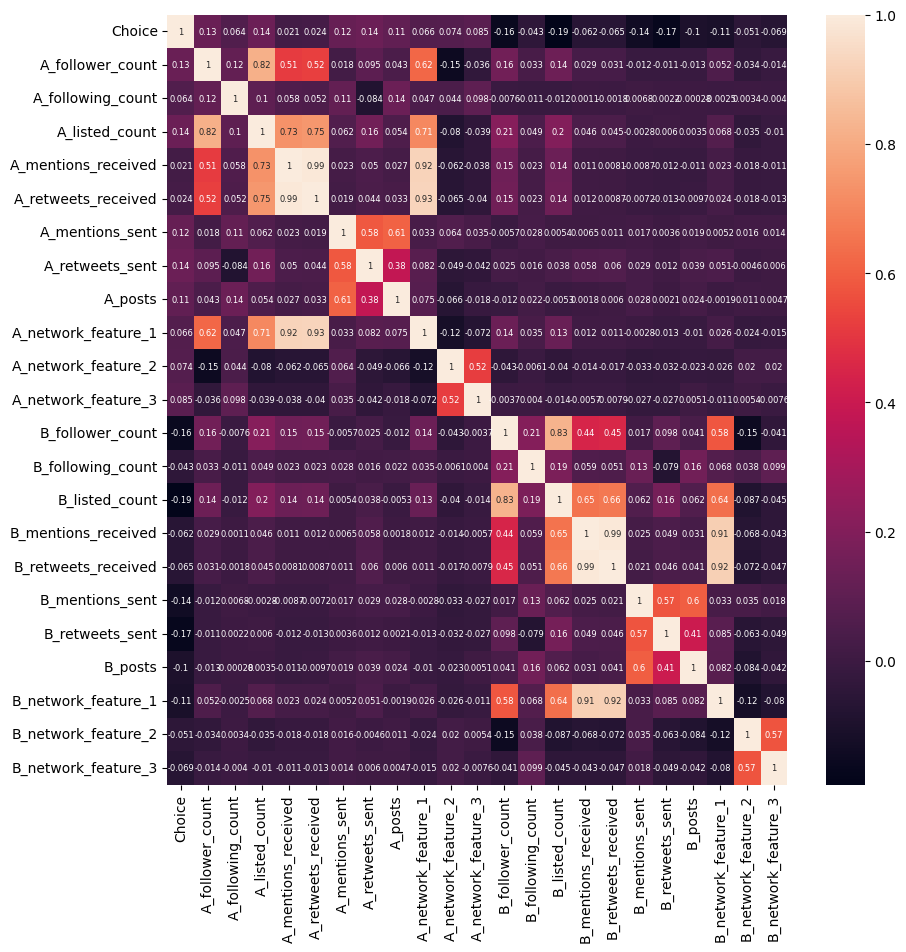

In [7]:
plt.figure(figsize = (10, 10))
sns.heatmap(data.corr(), annot = True, annot_kws={'size': 6})
plt.show()

### Feature engineering

In [72]:
## Creation of new features
data = create_new_variables(data)
data = replace_inf(data)

### Modeling

In [73]:
VARS = [
    'A_B_follow_ratio',
    'A_B_mention_ratio',
    'A_B_retweet_ratio',
    'A_B_followers_ratio',
    'A_B_following_ratio',
    'A_B_posts_ratio',
    'A_B_listed_ratio',
    'A_B_mentions_received_ratio',
    'A_B_mentions_sent_ratio',
    'A_B_retweets_received_ratio',
    'A_B_retweets_sent_ratio',
    'A_B_network_feature_1_ratio',
    'A_B_network_feature_2_ratio',
    'A_B_network_feature_3_ratio'
    ]

TARGET = ['Choice']

#### Machine learning approach

In [74]:
x = data[VARS]
y = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)


In [75]:
model_list = {
    'xgb':XGBClassifier(random_state = 123),
    'catboost':CatBoostClassifier(random_state = 123, verbose = False),
    'lgbm':LGBMClassifier(random_state = 123, verbose = -1),
    'randomForest':RandomForestClassifier(random_state = 123)
    }

list_metrics = []
for i in model_list.values():
    model = i
    model, metrics, cm = main_process(model,x_train, y_train, x_test, y_test, False, 0.5)
    list_metrics.append(metrics['auc'])

Text(0.5, 1.0, 'AUC score for different models')

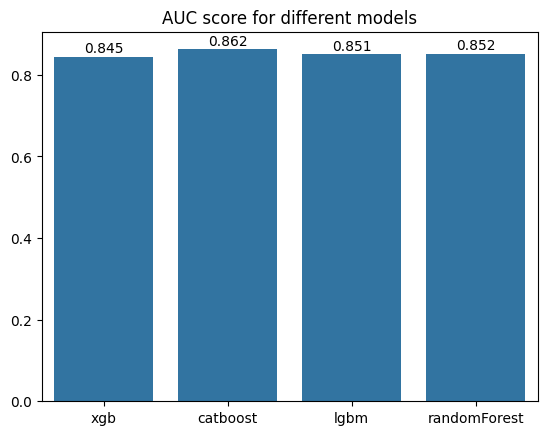

In [76]:
a = sns.barplot(x = list(model_list.keys()), y = list_metrics)

for i in range(len(list_metrics)):
    a.text(i, round(list_metrics[i],3) + 0.01, round(list_metrics[i],3), color='black', ha="center")
plt.title('AUC score for different models')

#### Deep learning approach

In [54]:
x = data.drop(columns = ['Choice'])
y = data[TARGET]
y = y.astype(np.float32)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)
x_training, x_validation, y_training, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=123)


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_training)
x_val_scaled = scaler.transform(x_validation)
x_test_scaled = scaler.transform(x_test)



input_shape = (11, 1)  # Number of features for each user
siamese_model = create_siamese_network(input_shape)

# Compile the model with Binary Crossentropy loss function
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape the input data for Conv1D layer
x_train_scaled = scale_data(x_train_scaled)
x_val_scaled = scale_data(x_val_scaled)
x_test_scaled = scale_data(x_test_scaled)
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = siamese_model.fit(
    [x_train_scaled[:, :11], x_train_scaled[:, 11:]], y_training,
    validation_data=([x_val_scaled[:, :11], x_val_scaled[:, 11:]], y_validation),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6141 - loss: 0.6667 - val_accuracy: 0.6625 - val_loss: 0.6125
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7106 - loss: 0.5643 - val_accuracy: 0.6943 - val_loss: 0.5767
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7076 - loss: 0.5510 - val_accuracy: 0.7148 - val_loss: 0.5589
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7357 - loss: 0.5170 - val_accuracy: 0.7091 - val_loss: 0.5597
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7377 - loss: 0.5266 - val_accuracy: 0.7114 - val_loss: 0.5571
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7511 - loss: 0.5068 - val_accuracy: 0.7352 - val_loss: 0.5351
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7596 - loss: 0.4951 - val_accuracy: 0.7409 - val_loss: 0.5269
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7577 - loss: 0.4914 - val_accuracy: 0.7455 - v

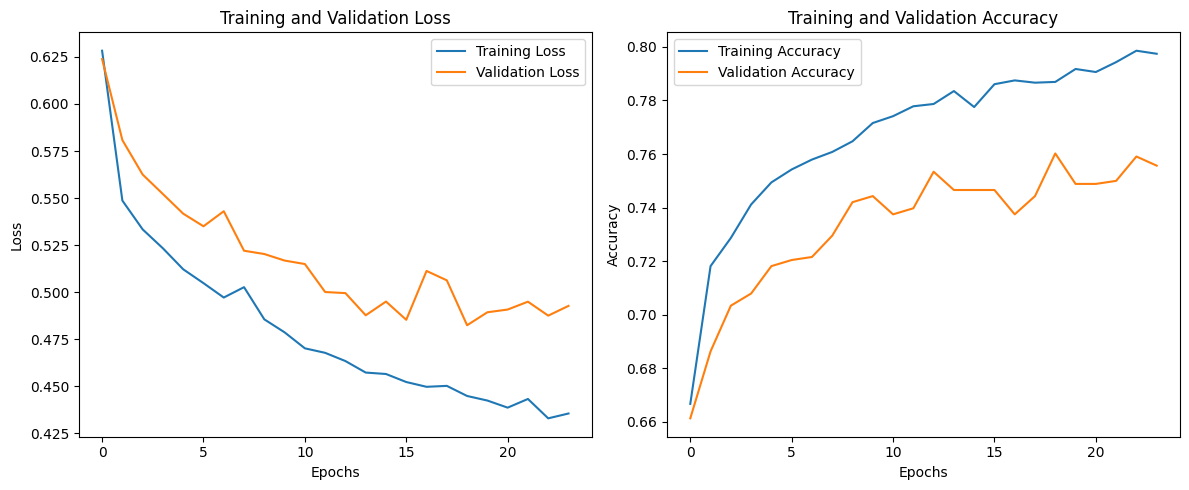

In [45]:
plot_training_validation(history)

In [65]:
predictions_proba = siamese_model.predict([x_test_scaled[:, :11], x_test_scaled[:, 11:]])
predictions_proba = predictions_proba.flatten()
predictions = np.where(predictions_proba > 0.5, 1, 0)
predictions_proba = predictions_proba.flatten()

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step


In [81]:
deep_learning_metrics = get_metrics(predictions, predictions_proba, y_test)
list_metrics.append(deep_learning_metrics[0]['auc'])

([0, 1, 2, 3, 4],
 [Text(0, 0, 'xgb'),
  Text(1, 0, 'catboost'),
  Text(2, 0, 'lgbm'),
  Text(3, 0, 'randomForest'),
  Text(4, 0, 'deep learning')])

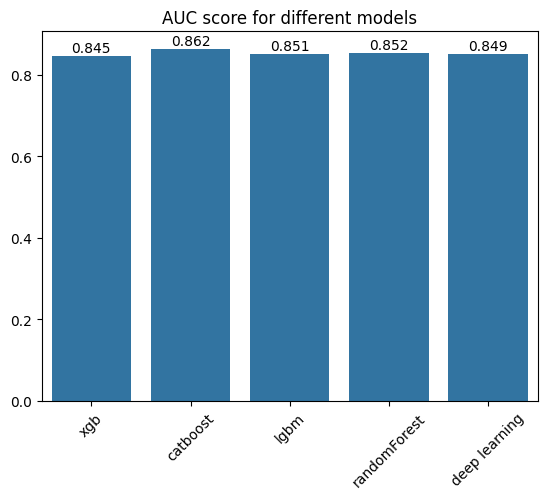

In [83]:
a = sns.barplot(x = list(model_list.keys()) + ['deep learning'], y = list_metrics)

for i in range(len(list_metrics)):
    a.text(i, round(list_metrics[i],3) + 0.01, round(list_metrics[i],3), color='black', ha="center")
plt.title('AUC score for different models')
plt.xticks(rotation = 45)

### Hyperparameter calibration

In [82]:
### Create validation set

x_training, x_val, y_training, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 123)
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, x_training, y_training, x_val, y_val), n_trials=100)

[I 2024-03-24 00:05:34,000] A new study created in memory with name: no-name-afa679ff-2346-4ccb-9311-309b1f965bce
[I 2024-03-24 00:05:34,127] Trial 0 finished with value: 0.8481508264462809 and parameters: {'objective': 'CrossEntropy', 'depth': 6, 'learning_rate': 0.08683670254645753, 'n_estimators': 8992, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'colsample_bylevel': 0.07475305313217372, 'subsample': 0.263786151088403}. Best is trial 0 with value: 0.8481508264462809.
[I 2024-03-24 00:05:35,914] Trial 1 finished with value: 0.8495712809917355 and parameters: {'objective': 'CrossEntropy', 'depth': 11, 'learning_rate': 0.01336029122587095, 'n_estimators': 3838, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'colsample_bylevel': 0.09843195463709552}. Best is trial 1 with value: 0.8495712809917355.
[I 2024-03-24 00:05:37,147] Trial 2 finished with value: 0.8481611570247936 and parameters: {'objective': 'CrossEntropy', 'depth': 4, 'learning_rate': 0.0204610091584059, 'n

### Optimizing threshold

In [117]:
best_params = {
    'objective': 'CrossEntropy',
    'depth': 10,
    'learning_rate': 0.054142680909405445,
    'n_estimators': 7625,
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'colsample_bylevel': 0.08320979403660492,
    'subsample': 0.6592979938870895
    }

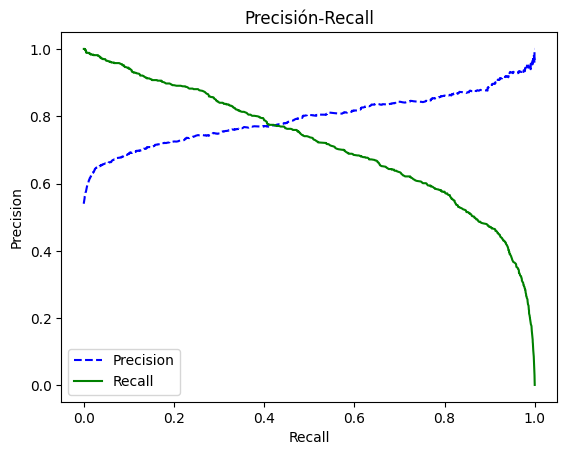

In [118]:
model = CatBoostClassifier(**best_params, random_state = 123, verbose = False)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)
model = training(model, x_train, y_train)
preds,probas = predict(model, x_test, 0.5)
precision, recall, threshold = plot_precision_recall(y_test, probas)

In [120]:
final_threshold = threshold[np.argmax(recall == precision)]
final_threshold

0.42269300878539556

### Final model

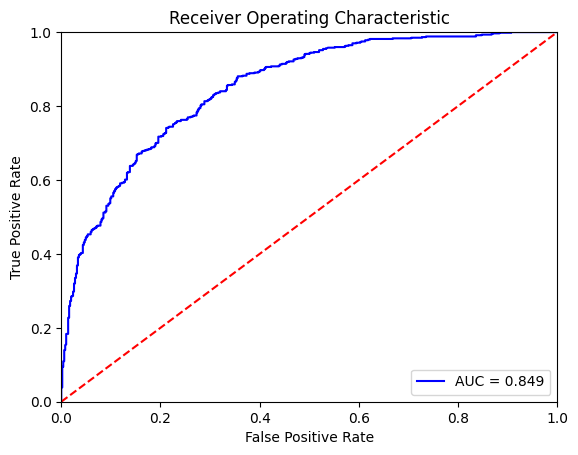

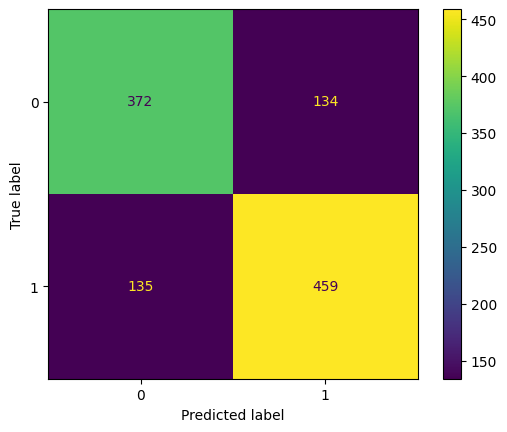

{'accuracy': 0.7554545454545455, 'sensitivity': 0.7727272727272727, 'specificity': 0.7351778656126482, 'auc': 0.8494713272381257}


In [122]:
final_model, metrics, cm = main_process(model, x_train, y_train, x_test, y_test, True, final_threshold, True)
print(metrics)

In [156]:
final_preds = np.where(final_model.predict_proba(x_test)[:,1]>final_threshold,1,0)

### Model interpretation



Text(0.5, 1.0, 'Feature importance')

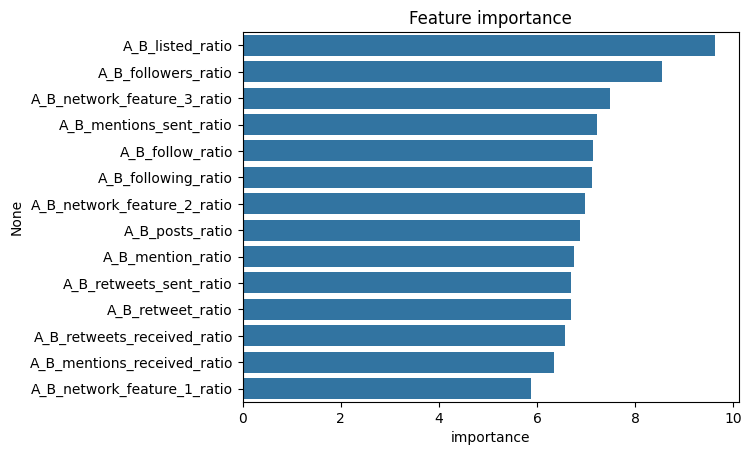

In [129]:
df_importance = pd.DataFrame(final_model.feature_importances_,final_model.feature_names_, columns = ['importance']).sort_values(by = 'importance', ascending = False)   
sns.barplot(x = df_importance['importance'], y = df_importance.index)
plt.title('Feature importance')

In [138]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(x_test)

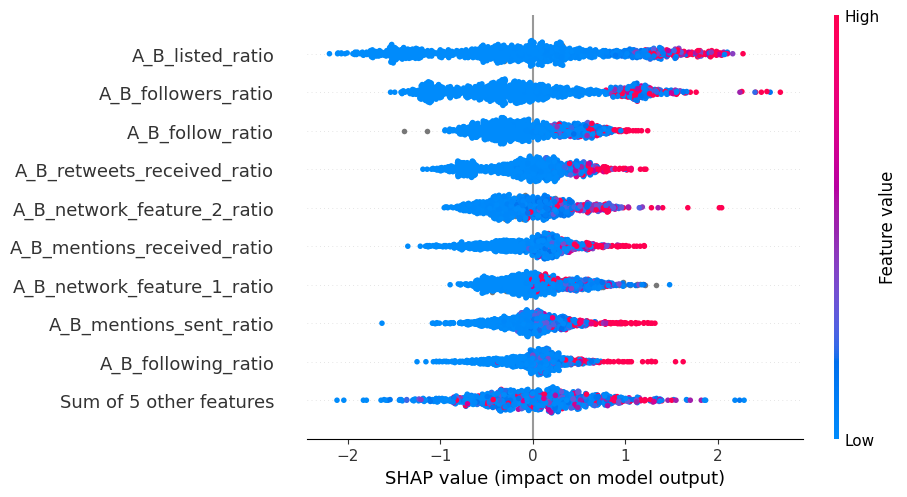

In [139]:
shap.plots.beeswarm(shap_values)

In [142]:
shap.initjs()
shap.plots.force(shap_values)

In [164]:
test = data.iloc[x_test.index]
test['preds'] = final_preds
test['revenue'] = np.where(
    (test['Choice'] == test['preds']) & (test['Choice']==1), (test['A_follower_count']*0.0003)-10, 
    np.where((test['Choice'] == test['preds']) & (test['Choice']==0), (test['B_follower_count']*0.0003)-10, 0))

test[['revenue']].sum()

revenue    311429.6136
dtype: float64

In [166]:
test['revenue_wo_analytics'] = np.where(test['Choice']==0, (test['B_follower_count']*0.0002)-5, 
                                        np.where(test['Choice']==1, (test['A_follower_count']*0.0002)-5, 0))
test[['revenue_wo_analytics']].sum()

revenue_wo_analytics    240676.8704
dtype: float64

## Part II: Networking analysis

In [9]:
df_submission = pd.read_json('data/0sanitymemes_submissions.zst' ,compression='infer',lines=True, encoding_errors = 'ignore')
df_comments = pd.read_json('data/0sanitymemes_comments.zst', compression='infer', lines=True)

In [10]:
### Preprocessing

df_result = network_preprocessing_analysis(df_comments, df_submission)

### Create the network

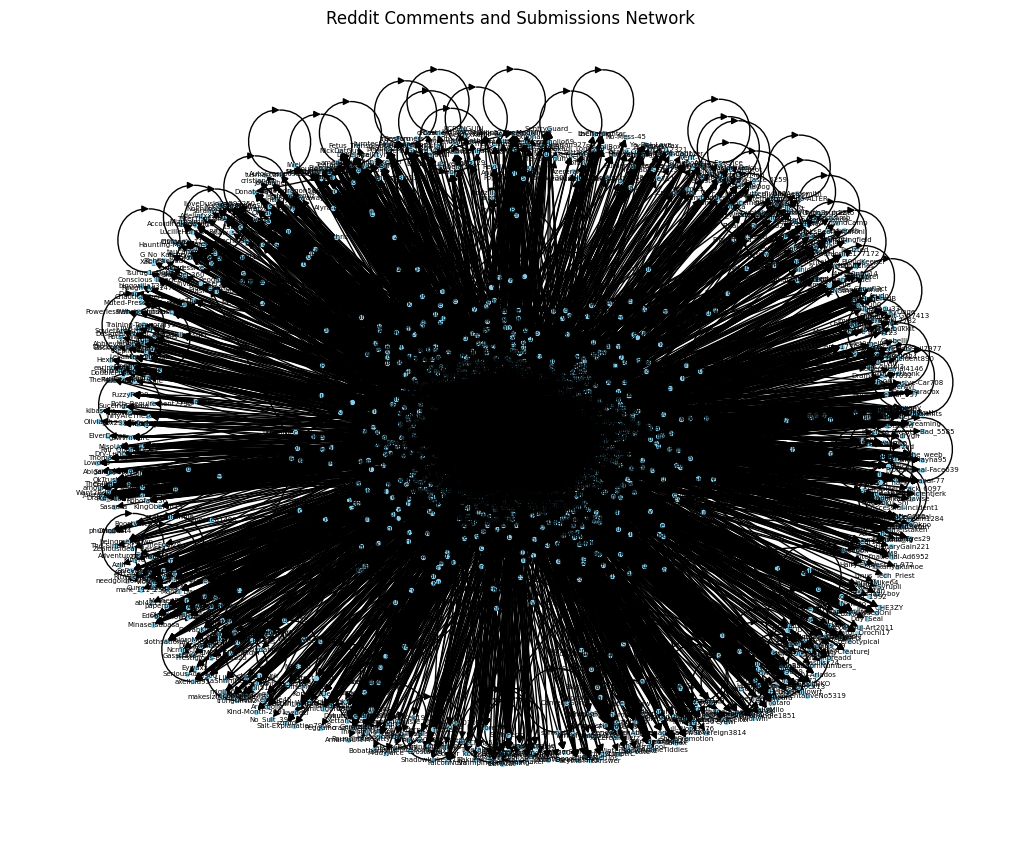

In [20]:
G = nx.DiGraph()

# Add edges from 'id_comment' to 'id_submission'
edges = df_result[['author_kid','author_parent']].values.tolist()
G.add_edges_from(edges)

plot_network(G, "Reddit Comments and Submissions Network")


In [40]:
submission_summary, comments_summary = get_metrics_per_author(df_comments, df_submission)
df_centralities = get_centrality_metrics(G)

author
[deleted]             1782
Randomkidinthehood     417
GlobelhHex             301
Golb89                 291
Hzuhairy               260
                      ... 
NSGParzival              1
NARESH4444               1
N333ko                   1
MyTwixAddiction          1
zombiegold7              1
Name: id, Length: 2770, dtype: int64

In [46]:
df_centralities_joined = pd.concat([df_centralities, submission_summary, comments_summary],axis = 1)
df_centralities_joined.columns = ['Degree','Betweenness','Closeness','#Posts',"#Comments"]

In [49]:
df_centralities_processed = preprocessing_metrics(df_centralities_joined)
weights = (0.2,0.2,0.2,0.2,0.2)
top_influencers = get_top_influencers(df_centralities_joined, weights,10)
top_influencers

author
GlobelhHex              1040.693668
P0lskichomikv2           664.295672
ATalkingDoubleBarrel     602.699195
JowettMcPepper           596.094125
Golb89                   586.882443
Rain_of_the_night-90     469.280640
mad_harvest-6578         464.886375
SteeeelFieeld            412.881514
LegionLegacyDMK          410.484461
aratnagrid               393.675443
Name: Score, dtype: float64

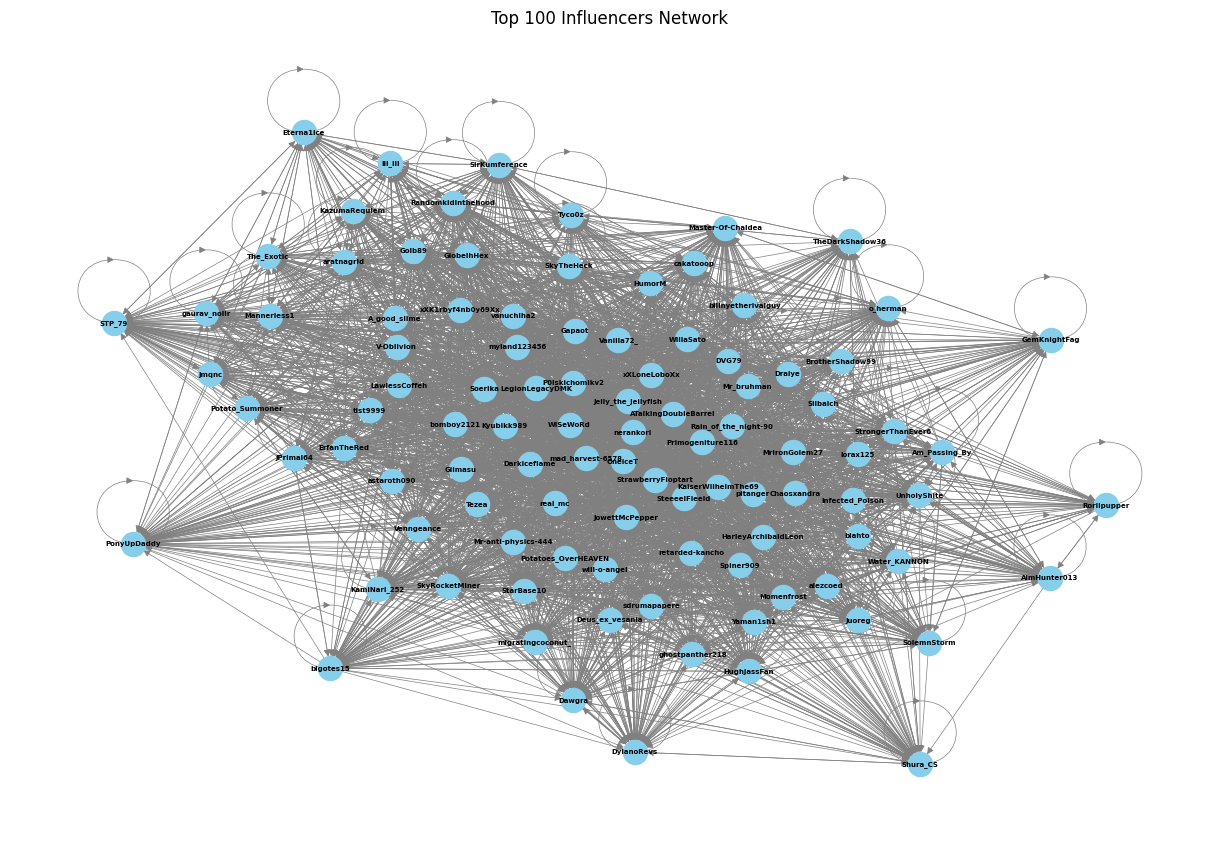

In [52]:
top_influencers_100 = get_top_influencers(df_centralities_joined, weights,100)

### Create subgraph with top 100 influencers
subgraph = G.subgraph(top_influencers_100.index)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, k=0.15)
nx.draw(subgraph, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=5, font_weight='bold', arrows=True, edge_color='gray', width=0.5)
plt.title("Top 100 Influencers Network")
plt.show()